In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import streamlit as st
from streamlit_lottie import st_lottie
import requests
from keras.models import load_model
from pandas_datareader import data as pdr
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, avg
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

C:\Users\Divyansh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
#pip install streamlit_lottie

In [4]:
yf.pdr_override()

def load_lottieurl(url: str):
    r = requests.get(url)
    if r.status_code != 200:
        return None
    return r.json()

In [5]:
spark = SparkSession.builder.appName("StockPredictionAnalytics").getOrCreate()

st.title("Stock Price Prediction and Big Data Analytics")

ticker = st.text_input("Enter Ticker Symbol", "AAPL")
df = pdr.get_data_yahoo(ticker, start="2010-01-01", end="2022-12-31")

st.subheader("Raw Data from 2010 to 2022")
st.write(df.describe())


2023-08-03 23:34:32.662 
  command:

    streamlit run C:\Users\Divyansh\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


[*********************100%***********************]  1 of 1 completed


In [6]:
# Splitting the data
train_data = pd.DataFrame(df['Close'][0:int(len(df) * 0.80)])  # 80%
test_data = pd.DataFrame(df['Close'][int(len(df) * 0.80): int(len(df))])  # 20%

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

train_data_arr = scaler.fit_transform(train_data)

In [7]:
# Splitting X and Y for predictions
x_train = []
y_train = []

for i in range(100, train_data_arr.shape[0]):
    x_train.append(train_data_arr[i - 100: i])
    y_train.append(train_data_arr[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
# Loading the model
model = load_model('LSTM_Model.keras')

In [9]:
# Testing the model
past_100_days = train_data.tail(100)
final_df = past_100_days.append(test_data, ignore_index=True)
input_data = scaler.fit_transform(final_df)

x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

C:\Users\Divyansh\AppData\Local\Temp\ipykernel_20052\2726421338.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(test_data, ignore_index=True)


In [10]:
# Making predictions
y_predicted = model.predict(x_test)
scaler = scaler.scale_

scale_factor = 1 / scaler[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

21/21 [==============================] - 1s 33ms/step


In [11]:
# Convert pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df.reset_index())

In [12]:
# Basic Data Analytics with PySpark
st.subheader("Basic Data Analytics with PySpark")

# Show the first few rows of the DataFrame
st.write("First few rows of the DataFrame:")

# Show the schema of the DataFrame
st.write("DataFrame Schema:")
st.write(spark_df.printSchema())

# Summary statistics of the 'Close' column
st.write("Summary statistics of the 'Close' column:")
st.write(spark_df.select("Close").summary())

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)



In [13]:
# Calculate rolling averages using PySpark
windowSpec100 = Window.orderBy("Date").rowsBetween(-99, 0)
spark_df = spark_df.withColumn("mvAvg100", avg(col("Close")).over(windowSpec100))

windowSpec200 = Window.orderBy("Date").rowsBetween(-199, 0)
spark_df = spark_df.withColumn("mvAvg200", avg(col("Close")).over(windowSpec200))

DeltaGenerator()

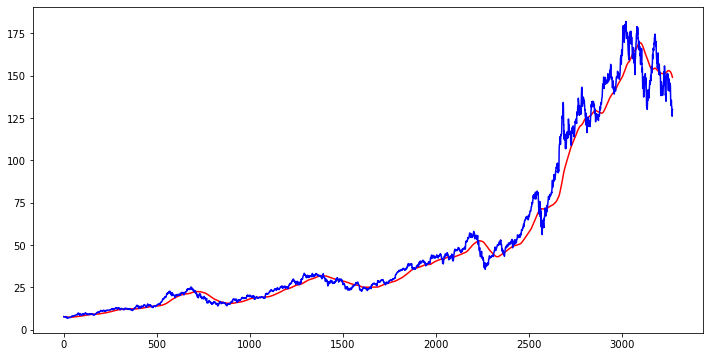

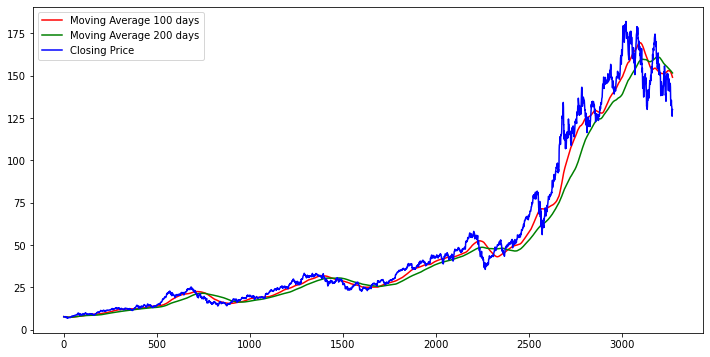

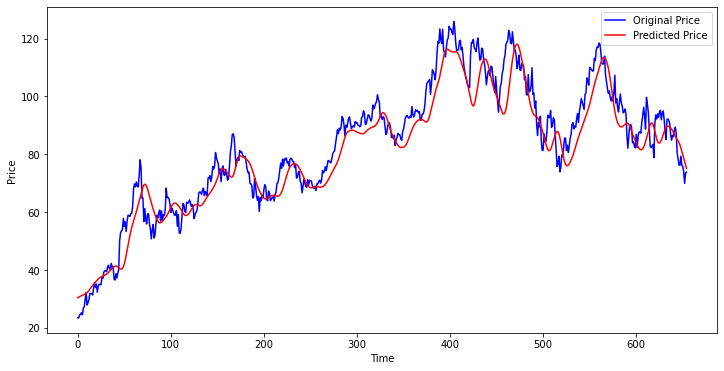

In [14]:
# Convert the PySpark DataFrame back to pandas DataFrame for visualization
df = spark_df.toPandas()

# Visualizing the predictions on the basis of moving average and original closing price
lottie_plot1 = load_lottieurl("https://lottie.host/f368e127-8990-49e8-91e7-6b79374bcc25/3jLlk8jgjw.json")
st.title("Stock Plots 📊")
st_lottie(lottie_plot1, speed=1, key="plot1")

st.subheader("Closing Price vs Time Chart with Moving Average 100 days")
fig = plt.figure(figsize=(12, 6))
plt.plot(df['mvAvg100'], 'r')
plt.plot(df['Close'], 'b')
st.pyplot(fig)

st.subheader("Closing Price vs Time Chart with Moving Average of 100 & 200 days")
fig = plt.figure(figsize=(12, 6))
plt.plot(df['mvAvg100'], 'r', label='Moving Average 100 days')
plt.plot(df['mvAvg200'], 'g', label='Moving Average 200 days')
plt.plot(df['Close'], 'b', label='Closing Price')
plt.legend()
st.pyplot(fig)

st.subheader("Predictions vs Original")
fig2 = plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
st.pyplot(fig2)

In [15]:
spark